
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [87]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json


## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).


# ***What?*** 
<200 words

My partner and I are planning to analyze the policy discourse on immigration over time comparing mainstream news sources and twitter discourse as well as trends over time. We hope to learn about how social media affected discourse on immigration policy, and whether this can be attributed to key events or shift in political administration or other changes over time or if it is plausible that this is unique to the change in medium of information generation and sharing. Immigration was chosen as the policy topic of study because of its neutrality in its root form compared to other more problematized policy areas such as poverty or inequality that are topics that signals an issue in a society.

## ***Why?***
<200 words

Social media has changed the way information is generated and consumed. With the rise of social media, information is no longer the monopoly of key players but instead there are now many more players generating and sharing and being part of the policy discourse. We see the power of social media to speak up on issues that have received less attention by the media. It is also an avenue where people from anywhere can critique and air their opinions on to support ethical journalism. However, there is also the issue of fake news and propagation of unhealthy sentiments. The results of this analysis would contribute to understanding how social media has shifted policy discussion on this specific topic on immigration policy, for better or worse or maybe a mix of both.
     
## ***How?***
<400 words

We will be using the text analysis methods learnt from class. Once we have gathered the datasets, we are first going to start by describing our data in terms of the relevant news articles and tweets we have gathered yearly and general descriptive statistics. We will then begin by preparing the dataset for analysis. This includes cleaning the text to remove html tags or other non-meaningful tags. We will then prepare the text for analysis using word tokenizing as well as normalization. We intend to keep all the text lowercased, to do stemming and lemmatization as well as to remove stop words and punctuation. 
    
For analysis, we intend to begin with a simple frequency analysis year on year for both datasets independently to get a sense of the top words that does not prefix with 'immigra' and to plot key words identified longitudinally. We will also do this for bigrams and trigrams. We intend to use the divergence measures in class to measure the similarity of the word distribution over time.

We also intend to do semantic networks to identify the words that are often used together with 'immigra' and potential cliques in these datasets year on year. Finally we will also look at clustering and topics of our datasets year on year. All these will again be compared using divergence measures to track the similarity and difference over time.
    
    
    
## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).


## ***Which (words)?***
<300 words

We will be sampling both twitter data as well as news data relevant to our topic of immigration policy. We are using the COCA corpus provided for the class as well as twitter data. Only the newspaper text and sources in COCA with text that contain 'immigra' will be used in this analysis. This data contain articles from 1990 to 2012. Since twitter was founded in March 2006, we also extracted twitter data from 2007 to 2019 by sampling the top 4 daily tweets that contain 'immigra' over the 13 years. 
    
We have chosen to use relevance sampling because our project studies that change of medium and changes over time for a constant topic. Relevance sampling would keep the signal of the text relevant to the project, but at the same time the changes we are exploring would allow us to analyze and draw insights. In addition, other virtues of this sample is also the length of data over time from the 1990s to allow us to draw insights of content trends over time versus content changes according to use of medium of information exchange. However, the data is clearly limited in that the usership of twitter and the COCA news sources are heavily US centred. It is also only focused narrowly on one policy topic. Finally, it also is just a exploratory study on associations rather than actual analysis on causation. 
    
A reasonable scaling up would definitely to get more varied social media sources such as Facebook and Instagram that have more international usership, as well as news sources. Analysis on a greater set of policy topics would also add much value to the analysis to understand if the results differ - however we had great difficulty choosing a neutral policy topic and sufficient topic and specification would need to go into that as well.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [88]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [89]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [90]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [91]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [92]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [93]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [94]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [95]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [96]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [97]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [98]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [99]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [100]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [101]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [102]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [103]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [104]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2


We can also look at the distinguishing features in each cluster:

In [105]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 window
 server
 use
 motif
 using
 widget
 program
 application
 code
 like


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 price
 interested
 best


Cluster 2:
 know
 thanks
 mac
 just
 does
 drive
 like
 apple
 don
 new


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 dealer
 new
 don




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [106]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [107]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [108]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

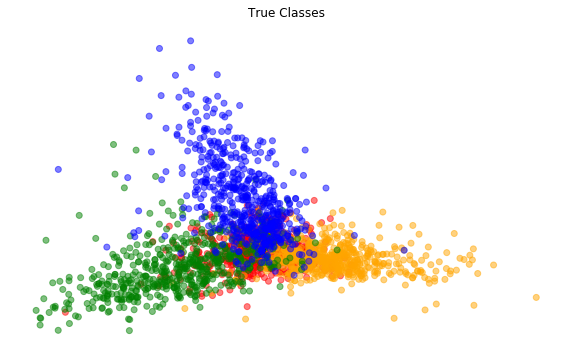

In [109]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

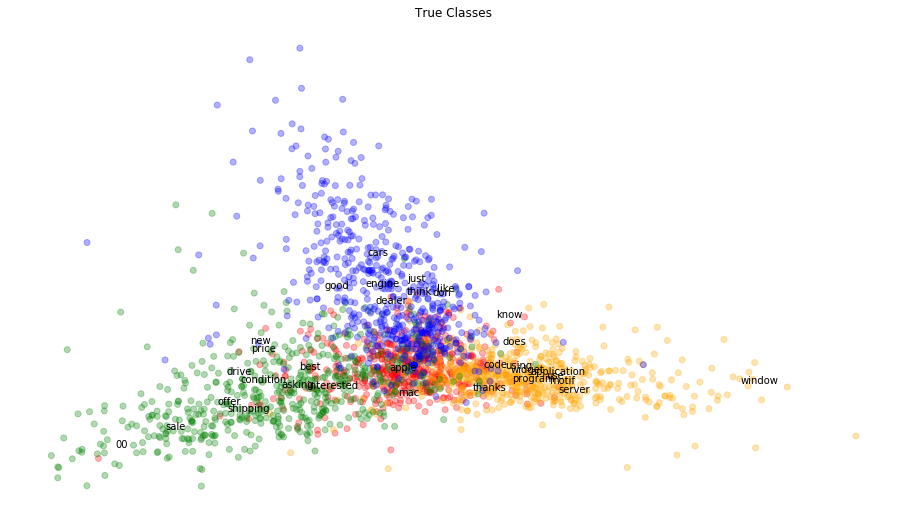

In [110]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [111]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

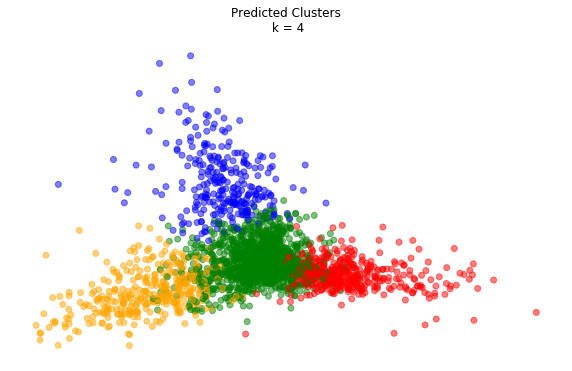

In [112]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [113]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [114]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")    
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


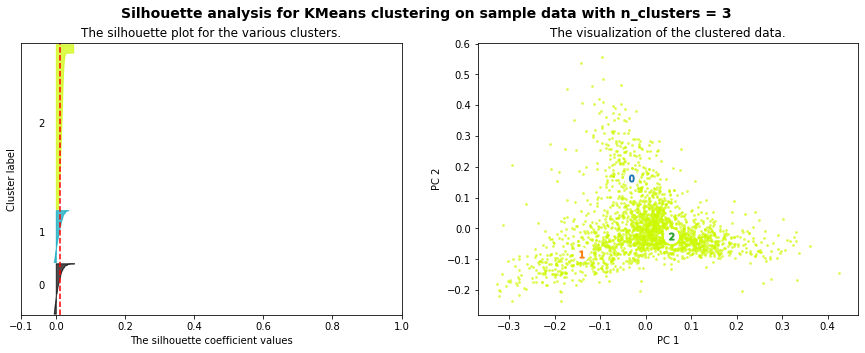

For n_clusters = 3, The average silhouette_score is : 0.013


In [115]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


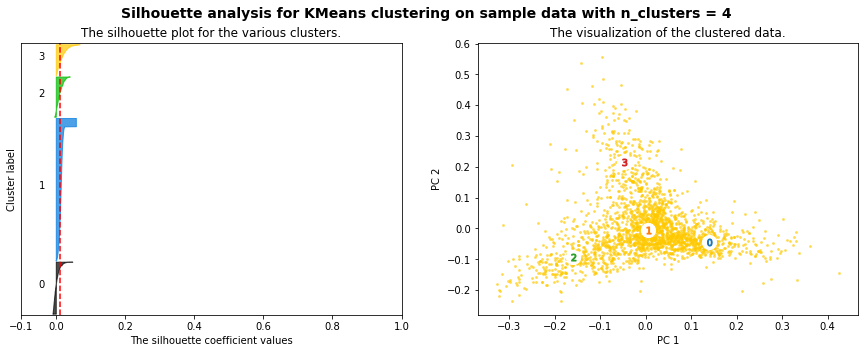

For n_clusters = 4, The average silhouette_score is : 0.012


In [116]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


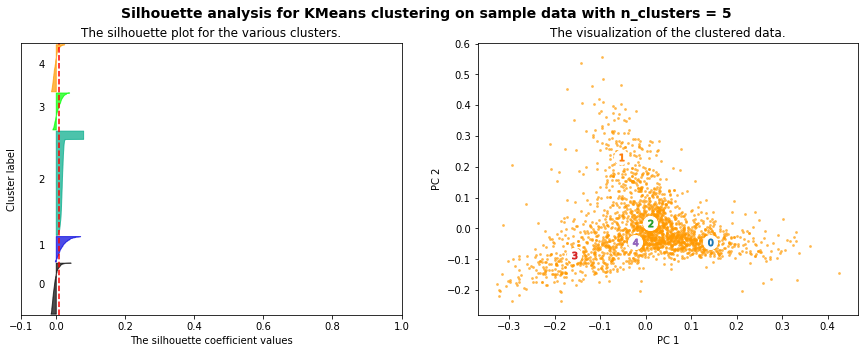

For n_clusters = 5, The average silhouette_score is : 0.010


In [117]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


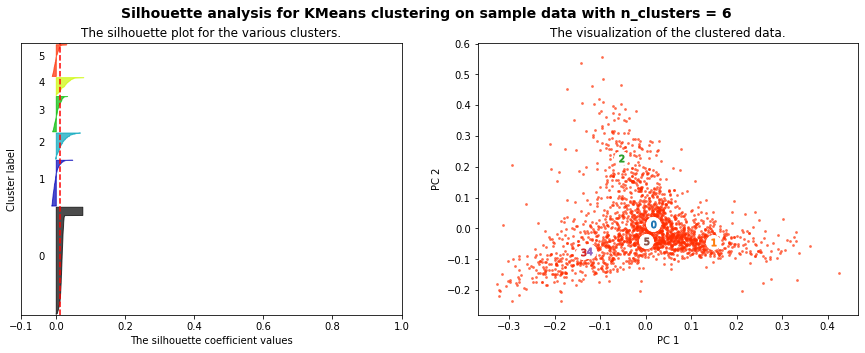

For n_clusters = 6, The average silhouette_score is : 0.011


In [118]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [33]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [34]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [35]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [36]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [37]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [38]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [39]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

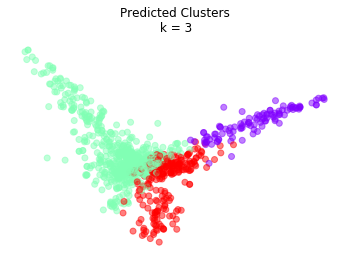

In [40]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [41]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,1
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [119]:
newspaper = pandas.read_csv("/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/twitterpolicydiscourse/data/immigra_coca_news.csv")

In [120]:
newspaper

,text_id,text,word_count,year,genre,subgen,source,title,publication_info
0,3001109,The people who work behind the pebble-glass ...,1960,1990,NEWS,138,NYTimes,"In School Bureaucracy, Despair at the System",NaN
1,3001113,Following are excerpts from a transcript of ...,2275,1990,NEWS,138,NYTimes,'This City Is Sick of Violence': Dinkins's Add...,NaN
2,3001115,"It started over some plantains and peppers ,...",1840,1990,NEWS,138,NYTimes,Black-Korean Who-Pushed-Whom Festers,NaN
3,3001128,"Sung Soo Kim , a native of South Korea , doe...",1509,1990,NEWS,138,NYTimes,Immigrants Help Others Lost in Maze,NaN
4,3001901,"Lucien Paye , head of the O.E.C.D. , which g...",714,1990,NEWS,142,NYTimes,FOREIGN AFFAIRS;The People Threat,NaN
...,...,...,...,...,...,...,...,...,...
3330,4115318,"For the second time in a month , the US Supre...",1232,2012,NEWS,135,CSMonitor,Arizona immigration law: states vs. Obama at U...,\r\n
3331,4115330,Sen. Scott Brown ( R ) of Massachusetts said ...,1126,2012,NEWS,135,CSMonitor,Brown calls on Harvard to correct record on El...,\r\n
3332,4115348,Insights into the minds of Westerners who hav...,1152,2012,NEWS,135,CSMonitor,American jihadi in Somalia writes an autobiogr...,\r\n
3333,4115354,An Obama administration announcement met by c...,1006,2012,NEWS,135,CSMonitor,Why some illegal immigrants arent celebrating ...,\r\n


In [121]:
# TFIDF vectoriser
coca_news_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
coca_newsVects = coca_news_vectoriser.fit_transform(newspaper['text'])

In [142]:
coca_news_vectoriser.stop_words_

{'calcite',
 'lissfaindance',
 'consummation',
 'rationally',
 'palmiers',
 'rayman',
 'liftoff',
 'devarona',
 'francia',
 'bathtubs',
 'leer',
 'garmo',
 'islamorada',
 'subplot',
 'maltose',
 'mudd',
 'dethronement',
 'hovers',
 'unhcr',
 'feral',
 'laird',
 'cannavale',
 'section',
 'belittled',
 'yes32',
 'woodforde',
 'lopezes',
 'complexions',
 'detornay',
 'fleshing',
 'storper',
 'rejoining',
 'steck',
 'glanville',
 'subsurface',
 '4651',
 'gillen',
 'pachmanov',
 'slouched',
 '2301',
 'reconfigured',
 'ultimates',
 'toothiest',
 'doomsayer',
 'sucursales',
 'plainfield',
 'pardoned',
 'syed',
 'kiesha',
 'avg',
 '1816',
 'slower',
 'thruster',
 'changers',
 'ampersand',
 'thrashed',
 'alvaro',
 'worthlessness',
 'ds',
 'kennell',
 'ales',
 'casework',
 'kremes',
 'brenci',
 'ethnobiologist',
 'hizbollah',
 'mezesvlle',
 'dermatitis',
 'lott',
 '303',
 'fissured',
 'defiance',
 'sussmuth',
 'intrusions',
 'chao',
 'delivers',
 '830',
 'triplicate',
 'hablar',
 'indicting',
 '

### 3 clusters

In [143]:
num_cluster = 3
km = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')

In [144]:
km.fit(coca_newsVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [201]:
newspaper['kmeans_prediction3'] = km.labels_

In [146]:
terms = coca_news_vectoriser.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_cluster):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 immigration
 editor
 government
 illegal
 percent
 law
 bush
 san
 federal
 political
 republican
 workers
 california
 million
 officials
 health
 clinton
 francisco
 tax
 border


Cluster 1:
 school
 children
 students
 black
 york
 percent
 parents
 community
 women
 street
 english
 mother
 young
 man
 father
 center
 church
 houston
 book
 film


Cluster 2:
 mr
 york
 police
 company
 ms
 united
 republican
 officer
 officials
 political
 lawyer
 campaign
 man
 officers
 case
 house
 bush
 government
 party
 office




In [147]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(coca_newsVects.toarray())
reduced_data = pca.transform(coca_newsVects.toarray())

In [148]:
# get distinguishing words to label
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [151]:
# set colors
colors = ['orange', 'green', 'blue']
colors_p = [colors[l] for l in km.labels_]

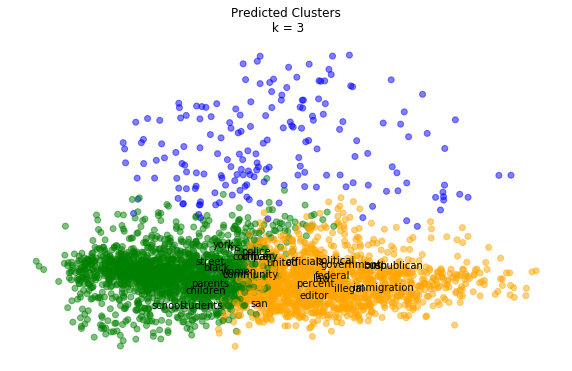

In [152]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
plt.show()

### Finding optimal cluster

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


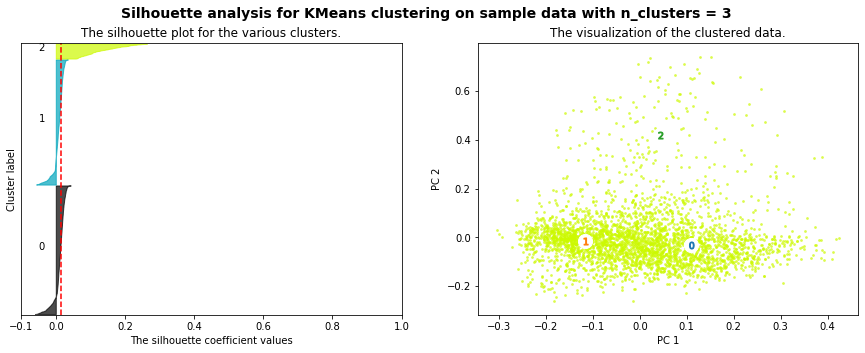

For n_clusters = 3, The average silhouette_score is : 0.015


In [153]:
coca_silhouette = coca_newsVects.toarray()
plotSilhouette(3, coca_silhouette)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


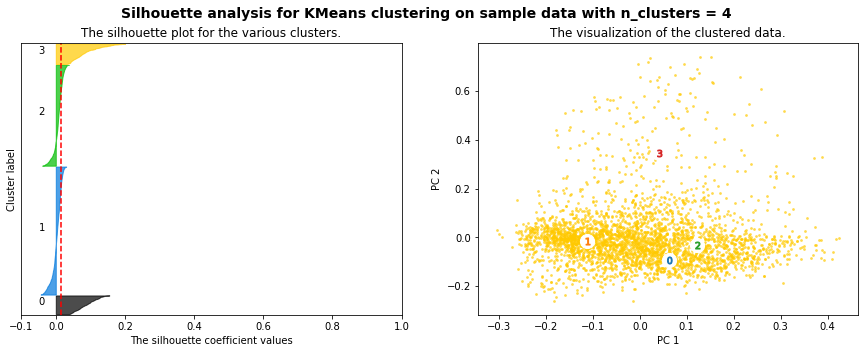

For n_clusters = 4, The average silhouette_score is : 0.016


In [154]:
plotSilhouette(4, coca_silhouette)

In [165]:
def find_best_n(X):
    clusters = []
    s_avg = []
    for i in range(2, 10):
        clusterer = sklearn.cluster.KMeans(n_clusters=i, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
        clusters.append(i)
        s_avg.append(silhouette_avg)
        print("For {} clusters, average silhouette score is {}".format(i, silhouette_avg))
    plt.plot(clusters, s_avg)
    plt.show()

For 2 clusters, average silhouette score is 0.015090283017181409
For 3 clusters, average silhouette score is 0.015497612596755687
For 4 clusters, average silhouette score is 0.016036779166396002
For 5 clusters, average silhouette score is 0.017330297857021476
For 6 clusters, average silhouette score is 0.019495698870893544
For 7 clusters, average silhouette score is 0.02181334708815194
For 8 clusters, average silhouette score is 0.024811163174054632
For 9 clusters, average silhouette score is 0.026081683935092293


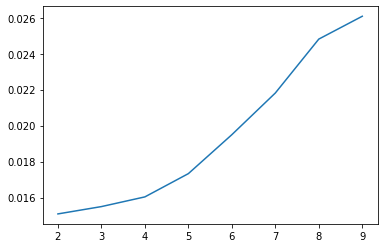

In [166]:
find_best_n(coca_silhouette)

It seems like the silhouette score increases with the number of clusters but taper off at above 8 clusters.

### 8 clusters

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


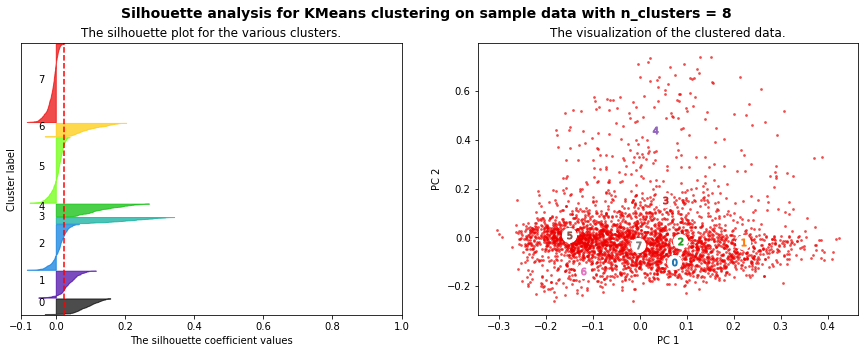

For n_clusters = 8, The average silhouette_score is : 0.025


In [167]:
plotSilhouette(8, coca_silhouette)

In [168]:
num_cluster = 8
km_8 = sklearn.cluster.KMeans(n_clusters=num_cluster, init='k-means++')

In [169]:
km_8.fit(coca_newsVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [177]:
terms = coca_news_vectoriser.get_feature_names()
print("Top terms per cluster:")
order_centroids = km_8.cluster_centers_.argsort()[:, ::-1]
for i in range(num_cluster):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 editor
 san
 francisco
 chronicle
 california
 bay
 clinton
 editorial
 article
 women


Cluster 1:
 mr
 york
 police
 company
 ms
 officer
 united
 lawyer
 officers
 political


Cluster 2:
 percent
 denver
 county
 million
 houston
 health
 colorado
 workers
 business
 money


Cluster 3:
 republican
 obama
 voters
 democrats
 bush
 campaign
 republicans
 senate
 party
 democratic


Cluster 4:
 israel
 government
 israeli
 europe
 minister
 arab
 united
 peace
 war
 officials


Cluster 5:
 immigration
 border
 illegal
 mexico
 law
 workers
 mexican
 federal
 legal
 enforcement


Cluster 6:
 children
 film
 book
 mother
 father
 man
 music
 black
 women
 york


Cluster 7:
 students
 school
 schools
 education
 teachers
 english
 student
 college
 parents
 children




In [235]:
# set colors
num_cluster=8
cmap = matplotlib.cm.get_cmap("nipy_spectral")
colors_p = [cmap(l/num_cluster) for l in km_8.labels_]

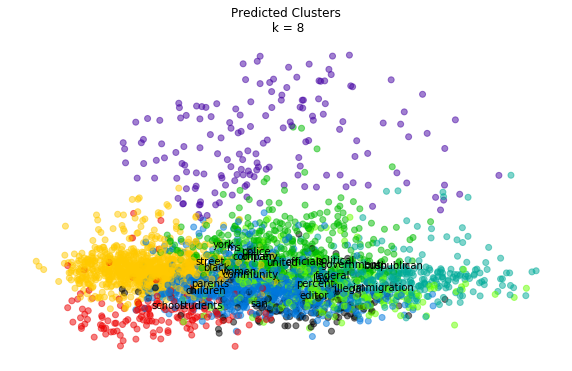

In [236]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_cluster))
plt.show()

I think it's interesting that the plot of the 3 clusters were pretty separate areas of the vector space. However, when looking at the top common words it seems that cluster 0 and 2 are pretty similar, while cluster 1 is more different. Cluster 1 had more terms like school, students, parents, black, man, father which were mostly identities and different roles in the community, in contrast cluster 0 and 2 were more political. Cluster 0 had words like government, illegal, san francisco, california, clinton, republican, tax, border and Cluster 2 had words like police, campaign, company, united, officer, government, republican. It seems like Cluster 0 highlights more state and policy words compared to cluster 2, but they appear to be quite closely related.

The silhouette score increases with the number of clusters but still remain low below 3%. It seems that 8 cluster may be a good number of cluster for this dataset. The clusters appear to be more homogenous and coherent. Cluster 0 seems to be on california, cluster 1 on actors such as the police, lawyer, officers, cluster 2 centred in dever, colorado and houston and talks about money, cluster 3 is political including democrats, republican and voters, cluster 4 is on foreign relations highlighting israel, arab, europe and peace and war issues, cluster 5 is focused on the border wall between US and mexico, cluster 6 seems to highlight immigrant families (including children, mother, father) and finally cluster 7 is focused on school, students, teachers and education. It is clear that there are different topics that are raised in the topic of immigration that is detectable using the cluster analysis.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [178]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [179]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [180]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [181]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [182]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [183]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[143.        , 145.        ,   0.        ,   2.        ],
       [148.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [119.        , 154.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        , 112.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

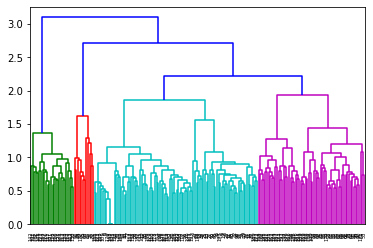

In [184]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

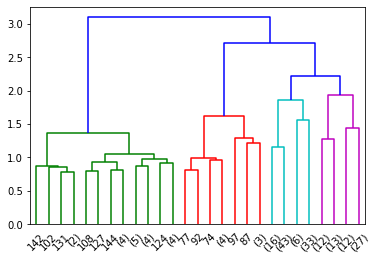

In [185]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [186]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [187]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [188]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,2,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,3,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,2,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [189]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

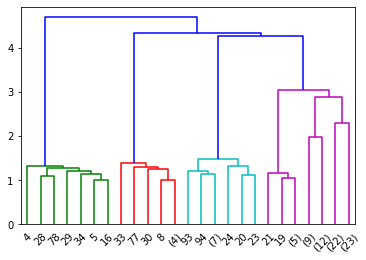

In [190]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [191]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

In [220]:
example_hierarchicalClusters_full[:20]

array([4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 3, 3, 4, 2, 4, 4, 4, 4, 4, 3],
      dtype=int32)

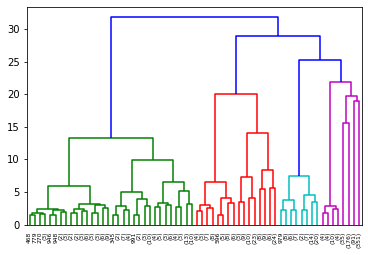

In [193]:
ax = scipy.cluster.hierarchy.dendrogram(example_linkage_matrix_full, p=5, truncate_mode='level')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

### Using Euclidean distance

In [192]:
coca_coocmat = coca_newsVects * coca_newsVects.T
coca_coocmat.setdiag(0)
cocalinkage_matrix_euclid = scipy.cluster.hierarchy.ward(coca_coocmat.toarray())

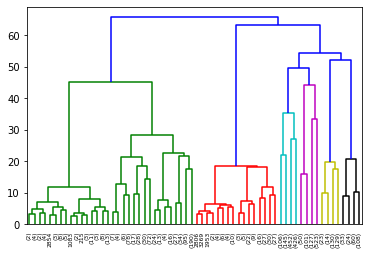

In [199]:
# truncating by levels 
ax = scipy.cluster.hierarchy.dendrogram(cocalinkage_matrix_euclid, p=5, truncate_mode='level')

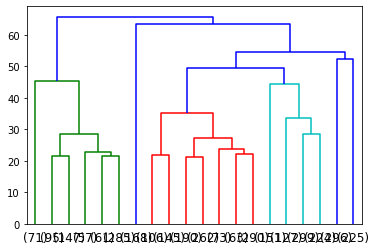

In [229]:
# truncating by last merged p
ax = scipy.cluster.hierarchy.dendrogram(cocalinkage_matrix_euclid, p=20, truncate_mode='lastp')

### 3 clusters

In [221]:
# saving f clusters
coca_news_hierarchicalclust = scipy.cluster.hierarchy.fcluster(cocalinkage_matrix_euclid, 3, 'maxclust')
newspaper["wald_predictions3"] = coca_news_hierarchicalclust

In [223]:
# set colors
colors = ['','orange', 'green', 'blue']
colors_p = [colors[l] for l in newspaper['wald_predictions3']]

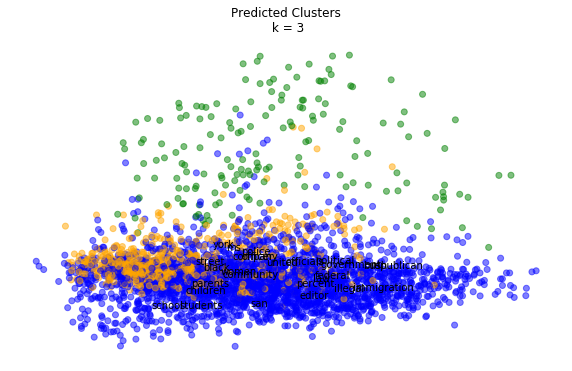

In [224]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

### max distance = 30

In [230]:
newspaper["wald_predictions_dist30"] = scipy.cluster.hierarchy.fcluster(cocalinkage_matrix_euclid, 30, 'distance')

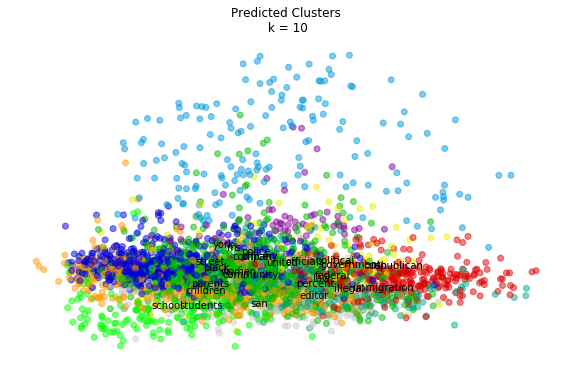

In [234]:
cmap = matplotlib.cm.get_cmap("nipy_spectral")
colors_p = [cmap(i/ len(newspaper['wald_predictions_dist30'].unique())) for i in newspaper['wald_predictions_dist30']]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(len(newspaper['wald_predictions_dist30'].unique())))
plt.show()

### Using cosine

In [248]:
cocalinkage_matrix_cosine= scipy.cluster.hierarchy.linkage(coca_coocmat.toarray(), method='complete', metric='cosine', optimal_ordering=False)
#The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, 
#‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, 
#‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

<ipython-input-248-d4cfb4c077af>:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cocalinkage_matrix_cosine= scipy.cluster.hierarchy.linkage(coca_coocmat.toarray(), method='complete', metric='cosine', optimal_ordering=False)


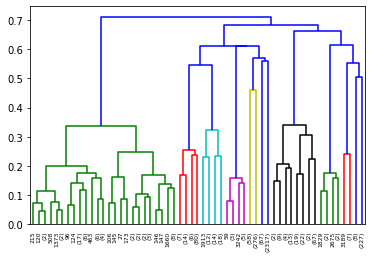

In [249]:
# truncating by levels 
ax = scipy.cluster.hierarchy.dendrogram(cocalinkage_matrix_cosine, p=5, truncate_mode='level')

In [250]:
# plot f clusters
colors = ['','orange', 'green', 'blue']
colors_p = [colors[l] for l in scipy.cluster.hierarchy.fcluster(cocalinkage_matrix_cosine, 3, 'maxclust')]

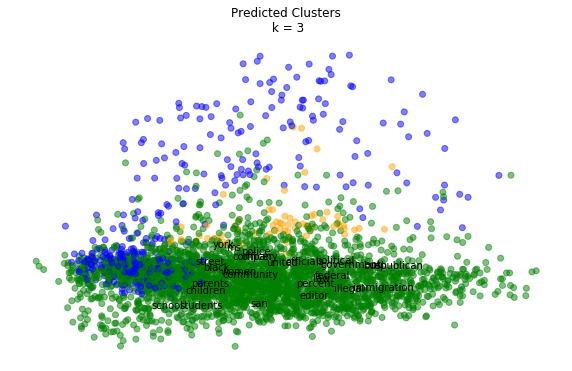

In [251]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

While the dendogram produced using cosine distanec is actually identical to the one given using ward's method/Euclidean distance, the three cluster in variable space is slightly different. Overall, cosine distance and Euclidean distance produced pretty similar results.

### Using correlation

In [252]:
cocalinkage_matrix_corr= scipy.cluster.hierarchy.linkage(coca_coocmat.toarray(), method='complete', metric='correlation', optimal_ordering=False)
#The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, 
#‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, 
#‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

<ipython-input-252-50d0bb255202>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cocalinkage_matrix_corr= scipy.cluster.hierarchy.linkage(coca_coocmat.toarray(), method='complete', metric='correlation', optimal_ordering=False)


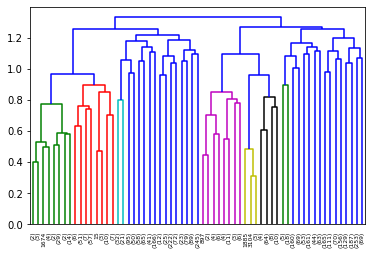

In [253]:
# truncating by levels 
ax = scipy.cluster.hierarchy.dendrogram(cocalinkage_matrix_corr, p=5, truncate_mode='level')

In [254]:
# plot f clusters
colors = ['','orange', 'green', 'blue']
colors_p = [colors[l] for l in scipy.cluster.hierarchy.fcluster(cocalinkage_matrix_corr, 3, 'maxclust')]

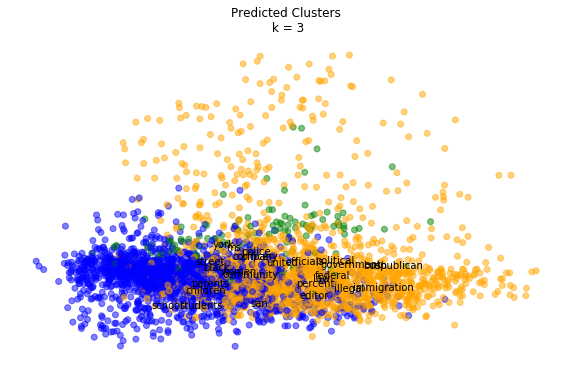

In [255]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

### Using jensenshannon

In [256]:
cocalinkage_matrix_js= scipy.cluster.hierarchy.linkage(coca_coocmat.toarray(), method='complete', metric='jensenshannon', optimal_ordering=False)
#The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, 
#‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, 
#‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

<ipython-input-256-9e0cd7cf3c0e>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  cocalinkage_matrix_js= scipy.cluster.hierarchy.linkage(coca_coocmat.toarray(), method='complete', metric='jensenshannon', optimal_ordering=False)


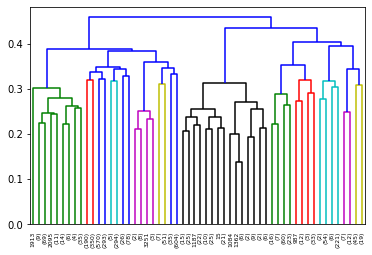

In [257]:
# truncating by levels 
ax = scipy.cluster.hierarchy.dendrogram(cocalinkage_matrix_js, p=5, truncate_mode='level')

In [258]:
# plot f clusters
colors = ['','orange', 'green', 'blue']
colors_p = [colors[l] for l in scipy.cluster.hierarchy.fcluster(cocalinkage_matrix_js, 3, 'maxclust')]

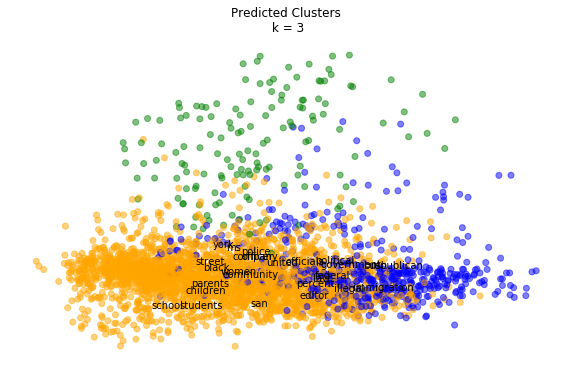

In [259]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

It appears that hierachical clustering does not do as well as k-means for this sample since the clusters are alot less homogenous and not so distinguishable. This is likely due to the definition of distance that does not correspond to the closeness of the semantic words in the space as seen in the plots of the clusters in vector space in the case of Euclidean and cosine distance. Correlation and jensen shannon distances produced pretty different clusters than Euclidean and cosine distances, and these were more distinct clusters and closer to that of k-means. 

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [260]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [261]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [262]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [263]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [264]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [265]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [272]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [273]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(0, 0.97319794)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [274]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [300]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(6, 0.9711931)]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.971193,0.000000,0.000000,0.000000
101,02Feb2007Kennedy10.txt,"[(1, 0.97648394), (7, 0.019082043)]",0.0,0.976484,0.000000,0.000000,0.000000,0.000000,0.000000,0.019082,0.000000,0.000000
201,04May2006Kennedy8.txt,"[(2, 0.019948281), (4, 0.73823524), (5, 0.2399...",0.0,0.000000,0.019948,0.000000,0.738235,0.239962,0.000000,0.000000,0.000000,0.000000
301,06Jun2007Kennedy1.txt,"[(2, 0.9680943), (7, 0.030059295)]",0.0,0.000000,0.968094,0.000000,0.000000,0.000000,0.000000,0.030059,0.000000,0.000000
401,08Feb2005Kennedy0.txt,"[(5, 0.91522473), (9, 0.0788472)]",0.0,0.000000,0.000000,0.000000,0.000000,0.915225,0.000000,0.000000,0.000000,0.078847
501,09Nov2005Kennedy11.txt,"[(5, 0.9554636)]",0.0,0.000000,0.000000,0.000000,0.000000,0.955464,0.000000,0.000000,0.000000,0.000000
601,11Nov2005Kennedy6.txt,"[(2, 0.067457356), (8, 0.907598)]",0.0,0.000000,0.067457,0.000000,0.000000,0.000000,0.000000,0.000000,0.907598,0.000000
701,13Jun2006Kennedy1.txt,"[(1, 0.44684464), (4, 0.24489224), (6, 0.20590...",0.0,0.446845,0.000000,0.000000,0.244892,0.000000,0.205901,0.000000,0.000000,0.100374
801,15Dec2005Kennedy5.txt,"[(3, 0.025755132), (7, 0.014899245), (8, 0.032...",0.0,0.000000,0.000000,0.025755,0.000000,0.000000,0.000000,0.014899,0.032946,0.925217
901,16May2007Kennedy5.txt,"[(1, 0.18234959), (9, 0.77653664)]",0.0,0.182350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.776537


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [301]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV
# ldaDFVis = ldaDFV.as_matrix(columns=None)
# ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
# ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.973197,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.971193,0.000000,0.000000,0.000000
2,0.368725,0.000000,0.000000,0.043598,0.0,0.000000,0.000000,0.000000,0.000000,0.582206
3,0.000000,0.000000,0.000000,0.000000,0.0,0.993960,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.997660,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.053293,0.000000,0.000000,0.0,0.726272,0.213646,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.041814,0.000000,0.0,0.000000,0.000000,0.364242,0.585811,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.0,0.584195,0.000000,0.000000,0.000000,0.386705
8,0.033954,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.017839,0.944304
9,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.967220


First we can visualize as a stacked bar chart:

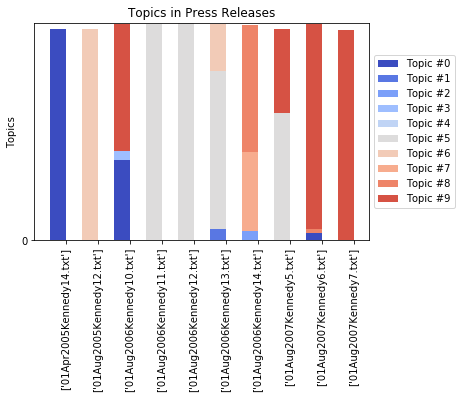

In [298]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

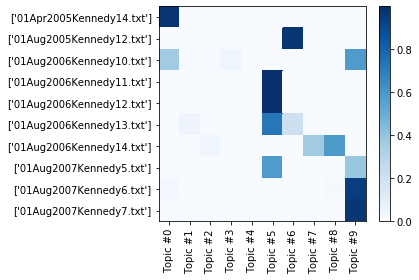

In [302]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [303]:
senlda.show_topic(1)

[('worker', 0.010684451),
 ('immigration', 0.005744968),
 ('fund', 0.00538144),
 ('immigrant', 0.0038435867),
 ('medicare', 0.0034880585),
 ('troop', 0.003431106),
 ('insurance', 0.0032970924),
 ('violence', 0.0032370284),
 ('asbestos', 0.003013348),
 ('victim', 0.0028827654)]

And if we want to make a dataFrame:

In [304]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,fund,worker,worker,worker,head,worker,minimum,worker,loan,loan
1,loan,immigration,fund,fund,fund,wage,wage,fund,fund,fund
2,worker,fund,pension,medicaid,worker,minimum,worker,judge,teacher,lender
3,fda,immigrant,unite,woman,asbestos,fda,fund,insurance,troop,worker
4,asbestos,medicare,head,coverage,victim,fund,troop,science,unite,aid
5,employee,troop,wage,loan,disease,company,company,immigration,judge,company
6,mental,insurance,immigration,hear,company,employee,citizen,wage,lender,unite
7,lender,violence,company,teacher,trust,immigration,rule,unite,commission,rate
8,troop,asbestos,medicare,agency,aid,pension,question,woman,follow,woman
9,test,victim,troop,fail,wage,employer,unite,train,rate,agency


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

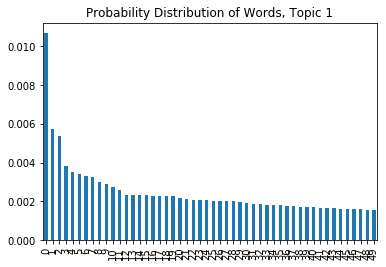

In [305]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [306]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

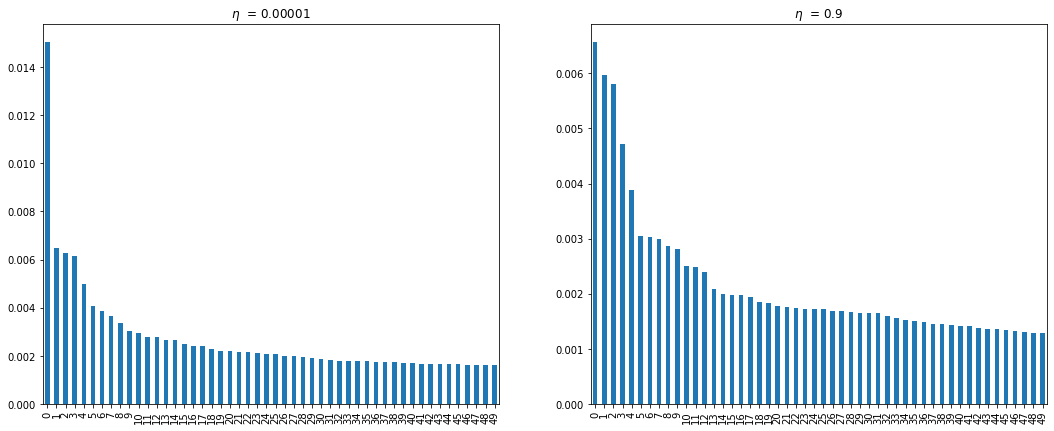

In [307]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [309]:
# Prepare text for analysis
newspaper['tokenized_text'] = newspaper['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newspaper['normalized_tokens'] = newspaper['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [310]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

newspaper['reduced_tokens'] = newspaper['normalized_tokens'].apply(lambda x: dropMissing(x, coca_news_vectoriser.vocabulary_.keys()))

In [311]:
# creating dictionary
newspaper_dictionary = gensim.corpora.Dictionary(newspaper['reduced_tokens'])

In [312]:
newspaper_corpus = [newspaper_dictionary.doc2bow(text) for text in newspaper['reduced_tokens']]

In [313]:
# serialize
gensim.corpora.MmCorpus.serialize('newspaper.mm', newspaper_corpus)
newspaper_mm = gensim.corpora.MmCorpus('newspaper.mm')

In [314]:
# topic modelling
newspaper_lda = gensim.models.ldamodel.LdaModel(corpus=newspaper_mm, id2word=newspaper_dictionary, num_topics=10, alpha='auto', eta='auto')

In [320]:
# create a df of text and topics
newspaper_ldaDF = pandas.DataFrame({
                'text_id' : newspaper['text_id'],
                'title': newspaper['title'],
                'year': newspaper['year'],
                'topics' : [newspaper_lda[newspaper_dictionary.doc2bow(l)] for l in newspaper['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(newspaper_ldaDF) for i in range(newspaper_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(newspaper_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(newspaper_lda.num_topics):
    newspaper_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

newspaper_ldaDF[1::100]

,text_id,title,year,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,3001113,'This City Is Sick of Violence': Dinkins's Add...,1990,"[(0, 0.0344143), (1, 0.20654668), (2, 0.222693...",0.034414,0.206547,0.222693,0.000000,0.302153,0.000000,0.000000,0.231854,0.000000,0.000000
101,3073330,Schools Join Self-Esteem Movement<BR>Novel pro...,1990,"[(0, 0.42537275), (4, 0.016889561), (6, 0.3767...",0.425373,0.000000,0.000000,0.000000,0.016890,0.000000,0.376743,0.000000,0.169484,0.000000
201,3032871,NEWS NEAR YOU,1991,"[(0, 0.28350133), (4, 0.1699812), (6, 0.521325...",0.283501,0.000000,0.000000,0.000000,0.169981,0.000000,0.521326,0.000000,0.000000,0.022851
301,3033084,NaN,1992,"[(3, 0.53689766), (7, 0.33794048), (9, 0.12269...",0.000000,0.000000,0.000000,0.536898,0.000000,0.000000,0.000000,0.337940,0.000000,0.122694
401,3027073,"HOME BUYERS HOLD OUT // Low rates, prices don'...",1993,"[(5, 0.47179142), (6, 0.522908)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.471791,0.522908,0.000000,0.000000,0.000000
501,3001325,"Left to Die, the South Bronx Rises From Decade...",1994,"[(1, 0.07621351), (4, 0.37743273), (6, 0.53383...",0.000000,0.076214,0.000000,0.000000,0.377433,0.000000,0.533835,0.000000,0.000000,0.000000
601,3047936,Bay Irish Americans Rally Around Belfast Fugit...,1994,"[(1, 0.5667704), (2, 0.30381066), (4, 0.024559...",0.000000,0.566770,0.303811,0.000000,0.024559,0.000000,0.000000,0.000000,0.000000,0.101851
701,3041972,TERROR HITS HOME;FORTRESS AMERICA;In the wake ...,1995,"[(1, 0.17290479), (3, 0.12146707), (4, 0.32609...",0.000000,0.172905,0.000000,0.121467,0.326096,0.000000,0.000000,0.121716,0.030565,0.224375
801,3013435,United by the Generosity of the Sky,1996,"[(0, 0.9907412)]",0.990741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
901,3054336,Odd alliance forms over annexation of Kingwood...,1996,"[(3, 0.30219904), (6, 0.6734799), (8, 0.021372...",0.000000,0.000000,0.000000,0.302199,0.000000,0.000000,0.673480,0.000000,0.021373,0.000000


In [519]:
newspaper_ldaDF['topics'][0]

[(0, 0.4868551), (4, 0.19824056), (6, 0.09033081), (8, 0.22177675)]

### Plot topics of first 10 documents

In [336]:
newspaper_ldaDFV = newspaper_ldaDF[:10][['topic_%d' %x for x in range(10)]]
newspaper_ldaDFVisN = newspaper_ldaDF[:10][['text_id']]
newspaper_ldaDFVis = newspaper_ldaDFV.values
newspaper_ldaDFVisNames = newspaper_ldaDFVisN.values
newspaper_ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.486855,0.000000,0.000000,0.000000,0.198241,0.000000,0.090331,0.000000,0.221777,0.000000
1,0.034414,0.206547,0.222693,0.000000,0.302153,0.000000,0.000000,0.231854,0.000000,0.000000
2,0.086878,0.239297,0.000000,0.000000,0.042012,0.000000,0.000000,0.538269,0.091314,0.000000
3,0.061672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307329,0.627391,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.698897,0.000000,0.292012
5,0.000000,0.158515,0.000000,0.000000,0.000000,0.277724,0.000000,0.546502,0.011693,0.000000
6,0.065068,0.000000,0.497475,0.000000,0.327807,0.000000,0.068867,0.035088,0.000000,0.000000
7,0.257083,0.332002,0.000000,0.000000,0.320535,0.000000,0.000000,0.082313,0.000000,0.000000
8,0.145852,0.000000,0.098609,0.000000,0.000000,0.000000,0.224733,0.084074,0.442824,0.000000
9,0.000000,0.423818,0.000000,0.013944,0.078168,0.010326,0.000000,0.363113,0.000000,0.108208


In [337]:
newspaper_ldaDFVis[:, 2]

array([0.        , 0.22269332, 0.        , 0.        , 0.        ,
       0.        , 0.497475  , 0.        , 0.0986094 , 0.        ])

In [340]:
def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title):
    N = 10
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

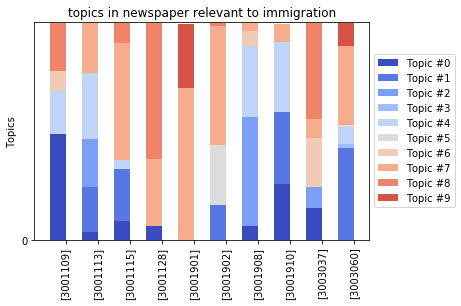

In [341]:
title = 'topics in newspaper relevant to immigration'
plot_topics_barchart(newspaper_lda, newspaper_ldaDFVis, newspaper_ldaDFVisNames, title)

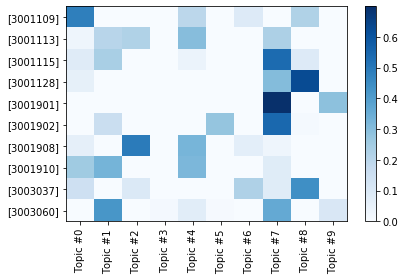

In [342]:
plt.pcolor(newspaper_ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(newspaper_ldaDFVis.shape[0])+0.5, newspaper_ldaDFVisNames);
topic_labels = ['Topic #{}'.format(k) for k in range(newspaper_lda.num_topics)]
plt.xticks(np.arange(newspaper_ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

### Identify topics by top words

In [343]:
topicsDict = {}
for topicNum in range(newspaper_lda.num_topics):
    topicWords = [w for w, p in newspaper_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

newspaper_topic_words = pandas.DataFrame(topicsDict)
newspaper_topic_words

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,child,live,story,law,school,percent,school,immigrant,mr,mr
1,school,worker,film,immigration,house,child,percent,immigration,immigrant,government
2,student,government,live,illegal,live,mr,student,group,school,house
3,tell,school,book,republican,police,market,house,business,percent,obama
4,leave,immigrant,man,party,child,company,county,mr,immigration,center
5,house,san,street,immigrant,official,job,build,job,california,health
6,look,child,include,democrat,help,business,houston,church,worker,campaign
7,late,border,play,vote,officer,music,live,live,san,include
8,young,job,theater,issue,man,help,art,community,house,plan
9,mother,black,movie,right,mr,money,group,worker,federal,war


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

In [346]:
def word_distribution_bytopic(topic):
    topic_df = pandas.DataFrame(newspaper_lda.show_topic(topic, topn=50))
    plt.figure()
    topic_df.plot.bar(legend = False)
    plt.title('Probability Distribution of Words, Topic {}'.format(topic))
    plt.show()

<Figure size 432x288 with 0 Axes>

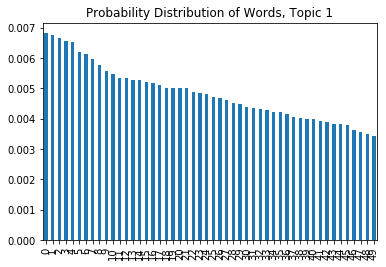

In [354]:
topic = 1
word_distribution_bytopic(topic)

### Changing alpha and eta

In [379]:
# Changing eta (Topic-word density - higher means topics are made up of most words in corpus)
newspaper_lda1 = gensim.models.ldamodel.LdaModel(corpus=newspaper_mm, id2word=newspaper_dictionary, num_topics=10, eta = 0.00001)
newspaper_lda2 = gensim.models.ldamodel.LdaModel(corpus=newspaper_mm, id2word=newspaper_dictionary, num_topics=10, eta = 0.9)

In [380]:
newspaper_lda1.show_topic(1, topn=10)

[('school', 0.01975045),
 ('student', 0.0102637),
 ('center', 0.0064673987),
 ('company', 0.00627035),
 ('include', 0.00615401),
 ('district', 0.005973141),
 ('house', 0.005879373),
 ('child', 0.005864789),
 ('york', 0.0056185937),
 ('mr', 0.005574398)]

In [381]:
newspaper_lda2.show_topic(1, topn=10)

[('immigrant', 0.018485788),
 ('immigration', 0.01662217),
 ('illegal', 0.010751838),
 ('law', 0.009850467),
 ('percent', 0.0076042404),
 ('worker', 0.007395555),
 ('job', 0.0067709796),
 ('issue', 0.0062141996),
 ('right', 0.0058645788),
 ('group', 0.0058067087)]

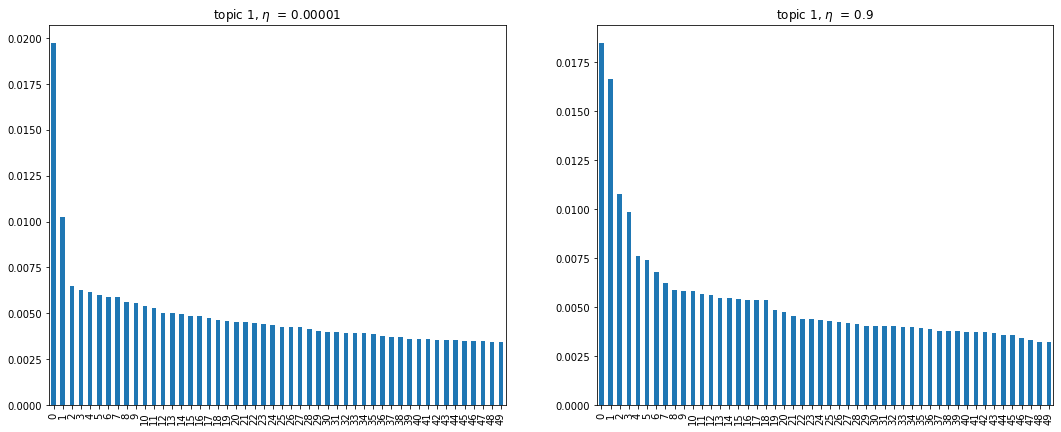

In [382]:
newspaper1_topic_df = pandas.DataFrame(newspaper_lda1.show_topic(1, topn=50))
newspaper2_topic_df = pandas.DataFrame(newspaper_lda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
newspaper1_topic_df.plot.bar(legend = False, ax = ax1, title = 'topic 1, $\eta$  = 0.00001')
newspaper2_topic_df.plot.bar(legend = False, ax = ax2, title = 'topic 1, $\eta$  = 0.9')
plt.show()

# more words in a topic with higher eta.

In [361]:
# Changing alpha (Document-topic density - higher means documents made up of more topics)
newspaper_lda3 = gensim.models.ldamodel.LdaModel(corpus=newspaper_mm, id2word=newspaper_dictionary, num_topics=10, alpha = 0.00001)
newspaper_lda4 = gensim.models.ldamodel.LdaModel(corpus=newspaper_mm, id2word=newspaper_dictionary, num_topics=10, alpha = 0.9)

In [362]:
newspaper_lda3.show_topic(1, topn=10)

[('school', 0.01491394),
 ('immigrant', 0.013489385),
 ('law', 0.011265473),
 ('immigration', 0.009258052),
 ('obama', 0.008457159),
 ('illegal', 0.008274247),
 ('student', 0.008200172),
 ('child', 0.00795752),
 ('right', 0.0071801427),
 ('program', 0.0070889737)]

In [363]:
newspaper_lda4.show_topic(1, topn=10)

[('percent', 0.011375832),
 ('immigrant', 0.011069284),
 ('immigration', 0.007869977),
 ('group', 0.007792604),
 ('school', 0.007122425),
 ('government', 0.006837828),
 ('live', 0.0064069694),
 ('law', 0.006080481),
 ('child', 0.0057830703),
 ('student', 0.0055393158)]

In [372]:
def create_topicdf(newspaper, newspaper_lda):
    # create a df of text and topics
    newspaper_ldaDF = pandas.DataFrame({
                    'text_id' : newspaper['text_id'],
                    'title': newspaper['title'],
                    'year': newspaper['year'],
                    'topics' : [newspaper_lda[newspaper_dictionary.doc2bow(l)] for l in newspaper['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(newspaper_ldaDF) for i in range(newspaper_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(newspaper_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(newspaper_lda.num_topics):
        newspaper_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    
    return newspaper_ldaDF


In [374]:
# small alpha - less topics
newspaper_lda3DF = create_topicdf(newspaper, newspaper_lda3)

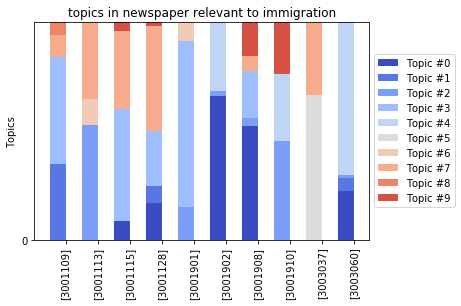

In [375]:
newspaper_ldaDFV = newspaper_lda3DF[:10][['topic_%d' %x for x in range(10)]]
newspaper_ldaDFVisN = newspaper_lda3DF[:10][['text_id']]
newspaper_ldaDFVis = newspaper_ldaDFV.values
newspaper_ldaDFVisNames = newspaper_ldaDFVisN.values

title = 'topics in newspaper relevant to immigration'
plot_topics_barchart(newspaper_lda3, newspaper_ldaDFVis, newspaper_ldaDFVisNames, title)

In [377]:
# bigger alpha - more topics
newspaper_lda4DF = create_topicdf(newspaper, newspaper_lda4)

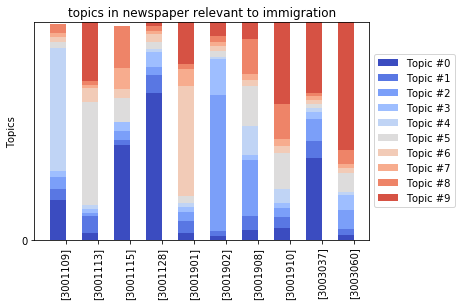

In [378]:
newspaper_ldaDFV = newspaper_lda4DF[:10][['topic_%d' %x for x in range(10)]]
newspaper_ldaDFVisN = newspaper_lda4DF[:10][['text_id']]
newspaper_ldaDFVis = newspaper_ldaDFV.values
newspaper_ldaDFVisNames = newspaper_ldaDFVisN.values

title = 'topics in newspaper relevant to immigration'
plot_topics_barchart(newspaper_lda4, newspaper_ldaDFVis, newspaper_ldaDFVisNames, title)

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [383]:
#corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"
filepath = "/Users/rachelker/Documents/UChic MSCAPP/Curriculum/2019-20 Winter/Computational Content Analysis/Project/Data/"
corpora_address = filepath+'Davies Corpora/SOAP'

In [384]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [385]:
import zipfile
import pandas as pd

In [386]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [387]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [388]:
soap_dict = {}

In [389]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [390]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [391]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [392]:
i = 0

In [393]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [394]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [395]:
dool = soap_df['Tokenized Texts'][9]

In [396]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [397]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [398]:
import networkx as nx

In [399]:
actor_network = nx.Graph()

In [400]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [401]:
i = 0

In [402]:
all_texts = []

In [403]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

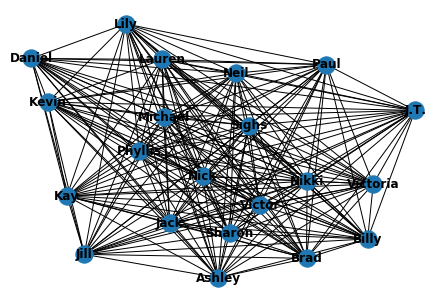

In [404]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [406]:
all_texts[0:10]

[['soon'],
 ['thank', 'god'],
 ['thank', 'miguel', 'look', 'real', 'hero', 'ryan', 'nicholas'],
 [],
 ['hey', 'rough', 'right'],
 ['house'],
 ['right',
  'be',
  'sure',
  'mamie',
  'like',
  'help',
  'look',
  'get',
  'right',
  'glad',
  'get',
  'joint',
  'man'],
 ['yes', 'care', 'boy', 'huh'],
 ['you', 'late'],
 ['yes', 'research', 'find', 'threat', 'husband', 'pose']]

In [407]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [408]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [409]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [410]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [411]:
doollda.show_topics()

[(0,
  '0.142*"right" + 0.057*"um" + 0.043*"let" + 0.043*"come" + 0.029*"need" + 0.028*"find" + 0.025*"sharon" + 0.024*"away" + 0.023*"work" + 0.019*"father"'),
 (1,
  '0.099*"know" + 0.058*"think" + 0.055*"oh" + 0.050*"get" + 0.031*"have" + 0.021*"maybe" + 0.017*"life" + 0.016*"thing" + 0.015*"man" + 0.014*"want"'),
 (2,
  '0.168*"okay" + 0.053*"talk" + 0.040*"sure" + 0.038*"be" + 0.037*"wait" + 0.028*"love" + 0.025*"jack" + 0.022*"want" + 0.020*"know" + 0.018*"worry"'),
 (3,
  '0.050*"want" + 0.034*"leave" + 0.024*"hold" + 0.022*"door" + 0.018*"lose" + 0.018*"family" + 0.017*"cell" + 0.017*"play" + 0.017*"miss" + 0.017*"company"'),
 (4,
  '0.108*"uh" + 0.054*"like" + 0.051*"mm" + 0.048*"hmm" + 0.027*"oh" + 0.023*"dad" + 0.021*"ask" + 0.020*"idea" + 0.019*"well" + 0.018*"billy"'),
 (5,
  '0.213*"yes" + 0.112*"na" + 0.109*"gon" + 0.054*"be" + 0.019*"bye" + 0.018*"fine" + 0.016*"oh" + 0.015*"newman" + 0.014*"daughter" + 0.012*"know"'),
 (6,
  '0.104*"be" + 0.092*"hey" + 0.044*"sorry" + 

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [412]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [413]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.08733993), (1, 0.03418382), (2, 0.056555916), (3, 0.12774454), (4, 0.025428034), (5, 0.26664174), (8, 0.28632683), (9, 0.11577737)]
[(0, 0.08731564), (1, 0.034867093), (2, 0.056791), (3, 0.13129564), (4, 0.024563432), (5, 0.26749474), (8, 0.28404185), (9, 0.113628305)]
[(0, 0.08257371), (1, 0.03366734), (2, 0.056288417), (3, 0.13373187), (4, 0.026099648), (5, 0.268131), (8, 0.2878922), (9, 0.111612394)]
[(0, 0.08842002), (1, 0.03076156), (2, 0.05801961), (3, 0.12802373), (4, 0.026558878), (5, 0.2692846), (8, 0.28441387), (9, 0.11451432)]
[(0, 0.08879438), (1, 0.031151114), (2, 0.05338638), (3, 0.12233702), (4, 0.028162612), (5, 0.26800138), (8, 0.28522998), (9, 0.122935385)]
[(0, 0.08847327), (1, 0.034442898), (2, 0.0569764), (3, 0.12098135), (4, 0.026874542), (5, 0.26920307), (8, 0.2869971), (9, 0.11604819)]
[(0, 0.08774833), (1, 0.03859877), (2, 0.054836214), (3, 0.12698573), (4, 0.026106251), (5, 0.26794478), (8, 0.28444296), (9, 0.11333472)]
[(0, 0.08703987), (1, 0.031848498

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [414]:
from gensim.matutils import kullback_leibler

In [415]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [416]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

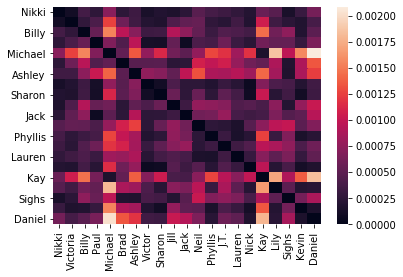

In [417]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [418]:
#corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"
corpora_address = filepath+'Davies Corpora/COHA'

In [419]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [421]:
list(coha_texts.keys())[0:10]

['mag_1940_148025.txt',
 'mag_1940_148026.txt',
 'mag_1940_148027.txt',
 'mag_1940_148028.txt',
 'mag_1940_148029.txt',
 'mag_1940_148030.txt',
 'mag_1940_148031.txt',
 'mag_1940_148032.txt',
 'mag_1940_148033.txt',
 'mag_1940_148034.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [422]:
coha_genres = {}
coha_years = {}

In [423]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [424]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [425]:
coha_years.keys()

dict_keys(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1980', '1981', '1982', '1983

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [426]:
import collections

In [427]:
years = []
year_lens = []

In [428]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [429]:
years[0], years[-1]

('1810', '2009')

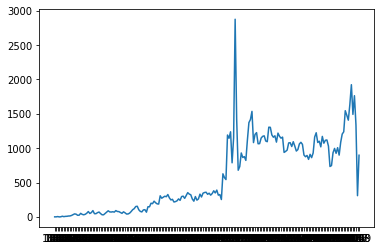

In [430]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [437]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

In [ ]:
docs_per_year

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [439]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [440]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [441]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [442]:
final_corpus= []

In [443]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [444]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [476]:
len(final_corpus)

4132

In [477]:
docs_per_time_slice

[803, 881, 859, 799, 790]

In [445]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [446]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [447]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [448]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [66]:
ldaseq.save("ldaseqmodel")

In [450]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

In [451]:
loaded_model.print_topics(time=0)[1]

[('state', 0.009231335276472926),
 ('man', 0.007395542533241843),
 ('great', 0.005407621887489939),
 ('power', 0.00466463108865709),
 ('time', 0.004145275353013492),
 ('government', 0.0038469615335645527),
 ('mr', 0.003784442892543364),
 ('people', 0.0034467994219777665),
 ('law', 0.0034071786078579145),
 ('new', 0.0030027721654430216),
 ('war', 0.002999489239112416),
 ('say', 0.0029620122071219437),
 ('year', 0.0027265764876598106),
 ('country', 0.0026961884570141158),
 ('general', 0.0026385043499987542),
 ('subject', 0.0025921116091278027),
 ('unite', 0.00243013848020865),
 ('interest', 0.0023961925608540803),
 ('mean', 0.002356244385602689),
 ('present', 0.002327481410279418)]

In [ ]:
loaded_model.print_topics(time=4)[4]



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

For my final project, my partner and I are looking at the trends of newpaper articles on immigration over time. Hence in this exercise I will look at dynamic topic modelling over time as well as measuring divergence of the topic distribution over time.

### Dynamic Topic Modelling

Text(0.5, 1.0, "Number of articles with 'immigra' in the news by year")

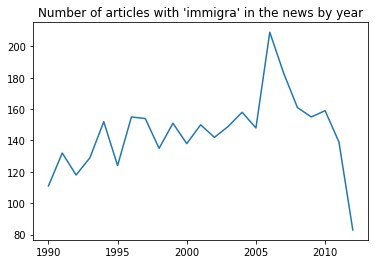

In [464]:
plt.plot(newspaper['year'].unique(), newspaper.groupby('year').size())
plt.title("Number of articles with 'immigra' in the news by year")

In [309]:
# # Prepare text for analysis
# newspaper['tokenized_text'] = newspaper['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
# newspaper['normalized_tokens'] = newspaper['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

# def dropMissing(wordLst, vocab):
#     return [w for w in wordLst if w in vocab]

# newspaper['reduced_tokens'] = newspaper['normalized_tokens'].apply(lambda x: dropMissing(x, coca_news_vectoriser.vocabulary_.keys()))

# # creating dictionary
# newspaper_dictionary = gensim.corpora.Dictionary(newspaper['reduced_tokens'])
# newspaper_corpus = [newspaper_dictionary.doc2bow(text) for text in newspaper['reduced_tokens']]

# # serialize
# gensim.corpora.MmCorpus.serialize('newspaper.mm', newspaper_corpus)
# newspaper_mm = gensim.corpora.MmCorpus('newspaper.mm')

In [478]:
from gensim.models import ldaseqmodel

In [481]:
docs_per_year = list(newspaper.groupby('year').size())

In [482]:
docs_per_year

[111,
 132,
 118,
 129,
 152,
 124,
 155,
 154,
 135,
 151,
 138,
 150,
 142,
 149,
 158,
 148,
 209,
 183,
 161,
 155,
 159,
 139,
 83]

In [593]:
newspaper_ldaseq = ldaseqmodel.LdaSeqModel(corpus=newspaper_mm, id2word=newspaper_dictionary, time_slice=docs_per_year, num_topics=4)

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [594]:
newspaper_ldaseq.save("newspaper_ldaseq4")

In [596]:
newspaper_ldaseq.print_topics(time=0)

[[('israel', 0.021928571414704244),
  ('government', 0.013945654234083118),
  ('soviet', 0.012976777800106592),
  ('political', 0.01190872888548936),
  ('right', 0.009495341837303295),
  ('bush', 0.009478101442936983),
  ('arab', 0.008627668726182954),
  ('war', 0.00834327088456769),
  ('issue', 0.008330403336829151),
  ('israeli', 0.008319210173593872),
  ('leader', 0.008108155794714482),
  ('mr', 0.007747006636973587),
  ('party', 0.007246917344708019),
  ('peace', 0.007166522622372412),
  ('official', 0.006743428427355039),
  ('vote', 0.006419667171806659),
  ('support', 0.0063797733628793),
  ('nation', 0.006335339494282528),
  ('policy', 0.006266961595987304),
  ('europe', 0.006115267679683384)],
 [('company', 0.017812452168113644),
  ('san', 0.013623225998768458),
  ('editor', 0.013307132703838523),
  ('newspaper', 0.011698733927329001),
  ('business', 0.010932004713392075),
  ('news', 0.010403385388233625),
  ('francisco', 0.009476820756464274),
  ('market', 0.008816826804471541

In [600]:
newspaper_ldaseq.print_topics(time=10)

[[('mr', 0.025803407089604203),
  ('government', 0.011955366985204031),
  ('vote', 0.01083181308485643),
  ('political', 0.010260387307414305),
  ('right', 0.009740474803842955),
  ('bush', 0.00970298848302976),
  ('campaign', 0.008312579079770677),
  ('party', 0.008275074791645269),
  ('issue', 0.007998486200449666),
  ('war', 0.007551990429853005),
  ('clinton', 0.007305672864544522),
  ('official', 0.007242738889336753),
  ('leader', 0.006736316170879895),
  ('election', 0.006701784070623681),
  ('law', 0.006033922853107245),
  ('house', 0.0059732925023785145),
  ('support', 0.0058045861274657684),
  ('israel', 0.00578973665891579),
  ('attack', 0.005695139926687051),
  ('nation', 0.005556753375654154)],
 [('company', 0.013279457763091104),
  ('business', 0.00996596936634444),
  ('san', 0.0096573226466925),
  ('percent', 0.009566883125971362),
  ('pay', 0.008820969741670613),
  ('job', 0.008581258021661174),
  ('worker', 0.0085092167362446),
  ('money', 0.007788129957277365),
  ('se

In [599]:
newspaper_ldaseq.print_topics(time=22)

[[('obama', 0.0278399279658533),
  ('mr', 0.016722411984567264),
  ('campaign', 0.01495182160370125),
  ('republican', 0.01427272090764455),
  ('vote', 0.013181560529106342),
  ('political', 0.012871227870447356),
  ('party', 0.012339004694632665),
  ('election', 0.009858307317177597),
  ('house', 0.009481204440892016),
  ('democrat', 0.009452361660633657),
  ('issue', 0.008936557926858206),
  ('candidate', 0.00856660843268258),
  ('republicans', 0.00847803646859267),
  ('senate', 0.008416045767191039),
  ('right', 0.008149806751741479),
  ('conservative', 0.007392891336190023),
  ('support', 0.007338672955874314),
  ('percent', 0.006888554161457322),
  ('national', 0.00668599406693617),
  ('democratic', 0.006401236295667616)],
 [('business', 0.014723935596171066),
  ('job', 0.014082057916277046),
  ('health', 0.012457744091819828),
  ('percent', 0.011184703341306385),
  ('house', 0.011126251052964343),
  ('pay', 0.010941740129295262),
  ('tax', 0.01057821449892586),
  ('need', 0.01020

### Divergence over time

In [484]:
from gensim.matutils import kullback_leibler

In [495]:
newspaper[newspaper['year']==1990][['text']]

,text
0,The people who work behind the pebble-glass ...
1,Following are excerpts from a transcript of ...
2,"It started over some plantains and peppers ,..."
3,"Sung Soo Kim , a native of South Korea , doe..."
4,"Lucien Paye , head of the O.E.C.D. , which g..."
...,...
106,"On this night , the answer was easy . For Pu..."
107,"Thursday , a somber but relaxed Lorenzo said..."
108,The joy of the veteran politician in that in...
109,Even as Israelis exult in the planeloads of ...


In [565]:
newsbyyear = {}
# Get topic distribution for each year
for yr in range(1990,2013):
    # get all text for each year
    text_df = newspaper[newspaper['year']==yr][['text']]
    text_df['tokenized_text'] = text_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
    text_df['normalized_tokens'] = text_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
    # create dictionary
    newspaper_dictionary_byyear = gensim.corpora.Dictionary(text_df['normalized_tokens'])
    newspaper_corpus_byyear = [newspaper_dictionary_byyear.doc2bow(text) for text in text_df['normalized_tokens']]
    # serialize
    gensim.corpora.MmCorpus.serialize('newspaper_byyear.mm', newspaper_corpus_byyear)
    newspaper_mm_byyear = gensim.corpora.MmCorpus('newspaper_byyear.mm')
    # lda
    newspaper_lda_byyear = gensim.models.ldamodel.LdaModel(corpus=newspaper_mm_byyear, id2word=newspaper_dictionary_byyear, num_topics=10, alpha='auto', eta='auto')
    
    # place topic distribution in dictionary
    all_text = []
    for text in text_df['normalized_tokens']:
        all_text.extend(text)
    newsbyyear[yr] = newspaper_lda_byyear[newspaper_dictionary_byyear.doc2bow(all_text)]
    
    print('{} done'.format(yr))

1990 done
1991 done
1992 done
1993 done
1994 done
1995 done
1996 done
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done


In [592]:
newsbyyear

{1990: [(0, 0.117879294), (2, 0.28636757), (4, 0.5119152), (9, 0.07387097)],
 1991: [(0, 0.010851734),
  (1, 0.033482656),
  (2, 0.012952674),
  (5, 0.47198054),
  (6, 0.18775421),
  (7, 0.05485547),
  (8, 0.22740872)],
 1992: [(0, 0.08714667),
  (1, 0.45722017),
  (2, 0.029296888),
  (4, 0.08637413),
  (7, 0.3239184)],
 1993: [(2, 0.07811042),
  (3, 0.26498595),
  (5, 0.121903494),
  (6, 0.19771251),
  (7, 0.082865536),
  (8, 0.16151367),
  (9, 0.08863969)],
 1994: [(0, 0.0118680615),
  (1, 0.13109876),
  (3, 0.087504245),
  (5, 0.52203846),
  (6, 0.0444635),
  (8, 0.13774079),
  (9, 0.055798933)],
 1995: [(2, 0.010260777), (4, 0.39625767), (5, 0.5471504), (6, 0.04244734)],
 1996: [(0, 0.012755657),
  (1, 0.024022773),
  (3, 0.049773615),
  (4, 0.4036075),
  (5, 0.4918494),
  (6, 0.012203928)],
 1997: [(0, 0.42637524),
  (3, 0.13165122),
  (4, 0.15426373),
  (6, 0.17131647),
  (8, 0.096917026)],
 1998: [(1, 0.015007055),
  (2, 0.35183087),
  (3, 0.22247523),
  (4, 0.25225636),
  (8, 0

In [581]:
topic_prob = {}

# Convert to probability
for yr in range(1990,2013):
    j=0
    for i in range(10):
        try:
            index, prob = newsbyyear[yr][j]
        except IndexError:
            index = False
        
        if index == i:
            j+=1
            if yr in topic_prob:  
                topic_prob[yr].append(prob)
            else:
                topic_prob[yr] = [prob]
        else:
            if yr in topic_prob:  
                topic_prob[yr].append(float(0))
            else:
                topic_prob[yr] = [float(0)]

In [582]:
topic_prob

{1990: [0.117879294,
  0.0,
  0.28636757,
  0.0,
  0.5119152,
  0.0,
  0.0,
  0.0,
  0.0,
  0.07387097],
 1991: [0.010851734,
  0.033482656,
  0.012952674,
  0.0,
  0.0,
  0.47198054,
  0.18775421,
  0.05485547,
  0.22740872,
  0.0],
 1992: [0.08714667,
  0.45722017,
  0.029296888,
  0.0,
  0.08637413,
  0.0,
  0.0,
  0.3239184,
  0.0,
  0.0],
 1993: [0.0,
  0.0,
  0.07811042,
  0.26498595,
  0.0,
  0.121903494,
  0.19771251,
  0.082865536,
  0.16151367,
  0.08863969],
 1994: [0.0118680615,
  0.13109876,
  0.0,
  0.087504245,
  0.0,
  0.52203846,
  0.0444635,
  0.0,
  0.13774079,
  0.055798933],
 1995: [0.0,
  0.0,
  0.010260777,
  0.0,
  0.39625767,
  0.5471504,
  0.04244734,
  0.0,
  0.0,
  0.0],
 1996: [0.012755657,
  0.024022773,
  0.0,
  0.049773615,
  0.4036075,
  0.4918494,
  0.012203928,
  0.0,
  0.0,
  0.0],
 1997: [0.42637524,
  0.0,
  0.0,
  0.13165122,
  0.15426373,
  0.0,
  0.17131647,
  0.0,
  0.096917026,
  0.0],
 1998: [0.0,
  0.015007055,
  0.35183087,
  0.22247523,
  

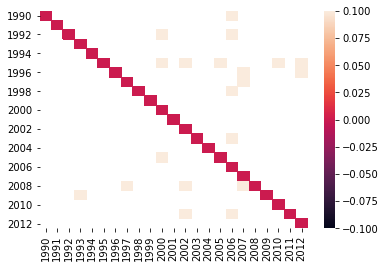

In [583]:
L = []
for year_1 in newsbyyear.keys():
    p = topic_prob[year_1]
    l = []
    for year_2 in newsbyyear.keys():
        q = topic_prob[year_2]
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

fig = plt.figure()
div = pandas.DataFrame(M, columns = list(newsbyyear.keys()), index = list(newsbyyear.keys()))
ax = sns.heatmap(div)
plt.show()

From the divergence analysis it seems that the topic distribution is pretty different every year and there is little similarities between the different years. It would be interesting to explore further the topics each year and how they change from one year to another and suggest why this is so.

It is probably notable that the similarity seems rather random based on the heatmap and requires further exploration. Why might 1993 and 2009 be more similar? Same for 1997 and 2008? These also applies to 2000 with 2005/1995/1992, 2002 with 1995/2008/2011, 2005 with 1995, 2006 with 1990/1992/1998/2003/2011/2007 , 2007 with 2007/1996/1997, 2010 with 1995, 2012 with 1995/1996.